# Visualize Model Coefficients

**Gregory Way, 2019**

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(ggrepel))

In [2]:
consensus <- "modz"

In [3]:
coef_dir <- file.path("figures", "coefficients")
figure_dir <- file.path(coef_dir, consensus)
results_dir <- "results"
empty_grob <- cowplot::ggdraw()

dir.create(figure_dir, recursive = TRUE, showWarnings = FALSE)

## Load Function

In [4]:
coef_plot <- function(
    df, target_name, compartment_features, coef_theme, top_plot_num = 15
) {
    # Compile a series of plots that describe model coefficients
    #
    # Arguments:
    # df - coefficient dataframe with feature metadata and weights
    # target_name - a string of a specific cell health model
    # compartment_features - a vector of which features to plot
    # coef_theme - a ggplot theme object to apply to all plots
    # top_plot_num - the number of top individual features to visualize
    
    # Subset the input dataframe to focus on the specific target
    subset_coef_df <- coef_df %>% dplyr::filter(target == !!target_name)

    # Extract and process specific feature sets
    area_df <- subset_coef_df %>%
        dplyr::filter(feature_group %in% c("AreaShape", "Neighbors")) %>%
        dplyr::group_by(shuffle, feature_group) %>%
        dplyr::mutate(feature_count = dplyr::n()) %>%
        dplyr::ungroup() %>%
        dplyr::group_by(shuffle, compartment, feature_group) %>%
        dplyr::top_n(n = 1, wt = abs_weight) %>%
        dplyr::group_by(compartment, feature_group, shuffle) %>%
        dplyr::mutate(abs_max_weight = max(abs_weight)) %>%
        dplyr::select(compartment, feature_group, shuffle, abs_max_weight, feature_count) %>%
        dplyr::distinct() %>%
        dplyr::ungroup() %>% 
        dplyr::mutate(feature_group = paste0(feature_group, " (n = ", feature_count, ")"),
                      weight_text = round(abs_max_weight, 2))

    # Merge compartments with correlation data summary
    compartment_df <- subset_coef_df %>%
        dplyr::filter(feature_group %in% !!compartment_features) %>%
        dplyr::group_by(shuffle, feature_group) %>%
        dplyr::mutate(feature_count = dplyr::n()) %>%
        dplyr::ungroup() %>%
        dplyr::group_by(shuffle, compartment, feature_group, channel) %>%
        dplyr::top_n(n = 1, wt = abs_weight) %>%
        dplyr::group_by(compartment, feature_group, channel, shuffle) %>%
        dplyr::mutate(abs_max_weight = max(abs_weight)) %>%
        dplyr::select(compartment, feature_group, channel, shuffle, abs_max_weight, feature_count) %>%
        dplyr::distinct() %>%
        dplyr::ungroup() %>% 
        dplyr::mutate(feature_group = paste0(feature_group, " (n = ", feature_count, ")"))

    corr_feature_count <- dim(subset_coef_df %>%
        dplyr::filter(feature_group == "Correlation", shuffle == "Real"))[1]

    correlation_df <- subset_coef_df %>%
        dplyr::filter(feature_group == "Correlation") %>%
        dplyr::group_by(channel, compartment, shuffle) %>%
        dplyr::mutate(abs_max_weight = max(abs_weight)) %>%
        dplyr::select(channel, compartment, shuffle, abs_max_weight) %>%
        dplyr::distinct() %>%
        dplyr::ungroup() %>%
        dplyr::mutate(feature_count = corr_feature_count,
                      feature_group = paste0("Colocalization (n = ", corr_feature_count, ")"))

    compartment_df <- dplyr::bind_rows(compartment_df, correlation_df)

    # Process individual feature name info
    total_features <- length(unique(subset_coef_df$feature))
    total_non_zero_features <- nrow(
        subset_coef_df %>%
            dplyr::filter(shuffle == "Real") %>%
            dplyr::filter(abs_weight > 0)
        )

    top_plot_num <- ifelse(total_non_zero_features < top_plot_num,
                           total_non_zero_features,
                           top_plot_num)

    feature_title <- paste0(
        round((total_non_zero_features / total_features) * 100, 2),
        "% Non-Zero"
    )

    top_n_features <- subset_coef_df %>%
        dplyr::filter(shuffle == "Real") %>%
        dplyr::top_n(n = top_plot_num, wt = abs_weight) %>%
        dplyr::pull(feature)

    feature_order <- subset_coef_df %>%
        dplyr::filter(shuffle == "Real") %>%
        dplyr::arrange(weight) %>%
        dplyr::pull(feature)

    subset_coef_features_df <- subset_coef_df %>%
        dplyr::filter(shuffle == "Real") %>%
        dplyr::filter(feature %in% !!top_n_features)

    subset_coef_features_df$feature <- factor(
        subset_coef_features_df$feature, levels = feature_order
    )

    min_gradient <- min(subset_coef_df$abs_weight)
    max_gradient <- max(subset_coef_df$abs_weight)

    # Draw an empty plot for later
    empty_grob <- ggdraw()

    # 1st Plot - Area Features
    # First, create an area background to fill missing elements
    area_comparments <- unique(area_df$compartment)
    area_feature_groups <- unique(area_df$feature_group)
    area_shuffle <- unique(area_df$shuffle)
    area_background <- tidyr::crossing(area_comparments, area_feature_groups, area_shuffle) %>%
        dplyr::mutate(weight_text = "N/A")
    colnames(area_background) <- c("compartment", "feature_group", "shuffle", "weight_text")

    # Now plot
    area_gg <- ggplot(area_df, aes(x = compartment, y = feature_group)) +
        geom_point(data = area_background, fill="grey", size = 5.5, pch = 22) +
        facet_wrap(~shuffle) +
        scale_fill_gradient2(
            name = "Max\nAbs. Weight",
            low = "white",
            high = "blue",
            limits = c(min_gradient, max_gradient)
        ) +
        ylab("Feature Group") +
        xlab("Compartment") +
        theme(axis.text.y = element_text(angle = 90, hjust = 0.5)) +
        theme_bw() +
        coord_fixed() +
        geom_text(aes(label = weight_text), size = 1.3, data = area_background) +
        geom_point(aes(fill = abs_max_weight), size = 5.5, pch = 22) +
        geom_text(aes(label = weight_text), size = 1.3) +
        coef_theme +
        theme(axis.text.x = element_text(angle = 45, hjust = 1))

    # 2nd Plot - Other Compartment Features
    # First, create a background to fill missing elements
    comp_compartments <- unique(compartment_df$compartment)
    comp_channels <- unique(compartment_df$channel)
    comp_feature_groups <- unique(compartment_df$feature_group)
    comp_shuffle <- unique(compartment_df$shuffle)
    comp_background <- tidyr::crossing(comp_compartments, comp_channels, comp_feature_groups, comp_shuffle) %>%
        dplyr::mutate(weight_text = "N/A")
    colnames(comp_background) <- c("compartment", "channel", "feature_group", "shuffle", "weight_text")

    # Now, plot
    compartment_gg <- ggplot(compartment_df,
                             aes(x = channel, y = feature_group)) +
        geom_point(data = comp_background, fill="grey", size = 4.2, pch = 22) +
        facet_grid(compartment~shuffle) +
        scale_fill_gradient2(
            name = "Weighted\nCoeffients\nAbs. Max",
            low = "white",
            high = "blue",
            limits = c(min_gradient, max_gradient)
        ) +
        ylab("Feature Group") +
        xlab("Channel") +
        coord_fixed() +
        theme_bw() +
        geom_text(aes(label = weight_text), size = 1.25, data = comp_background) +
        geom_point(aes(fill = abs_max_weight), size = 4.2, pch = 22) +
        geom_text(aes(label = round(abs_max_weight, 2)), size = 1.25) +
        coef_theme +
        theme(axis.text.x = element_text(angle = 90))

    # 3th Plot - Individual Feature Names
    feature_name_gg <- ggplot(subset_coef_features_df,
                              aes(x = feature, y = weight, fill = abs(weight))) +
        geom_bar(color = "black", stat = "identity") +
        scale_fill_gradient2(
                name = "Abs. Weight",
                low = "white",
                high = "blue",
                limits = c(min_gradient, max_gradient)
            ) +
        ggtitle(feature_title) +
        coord_flip() +
        xlab("") +
        ylab("Model Coefficient") +
        theme_bw() +
        coef_theme +
        theme(legend.position = "none", axis.text.x = element_text(angle = 90))

    # Get cowplot title
    use_title <- label_df %>%
        dplyr::filter(id == !!target) %>%
        dplyr::pull(readable_name)

    full_title <- ggdraw() + 
      draw_label(
          use_title,
          fontface = 'bold',
          x = 0,
          hjust = -0.1
      )
    coef_legend <- cowplot::get_legend(compartment_gg)

    right_panel <- cowplot::plot_grid(
        area_gg + theme(legend.position = "none",
                        plot.margin = margin(1.3, 1, 1, 1)),
        compartment_gg + theme(legend.position = "none",
                               plot.margin = margin(1.3, 1, 1, 1)),
        rel_heights = c(0.5, 1),
        nrow = 2,
        align = "h",
        axis = "l"
    )

    full_panel <- cowplot::plot_grid(
        feature_name_gg + theme(plot.margin = margin(1, 1, 1, 1)),
        right_panel,
        align = "none",
        rel_widths = c(1, 0.9)
    )

    coef_full_gg <- cowplot::plot_grid(
        full_panel,
        coef_legend,
        rel_widths = c(1, 0.1)
    )

    coef_gg <- cowplot::plot_grid(
        full_title,
        coef_full_gg,
        nrow = 2,
        rel_heights = c(0.1, 1)
        )
    
    return(coef_gg)
}

## Load Data and Process Feature Info

In [5]:
# Annotated Cell Health Features
feat_file <- file.path(
    "..",
    "1.generate-profiles",
    "data",
    "labels",
    "feature_mapping_annotated.csv"
)

label_df <- readr::read_csv(feat_file, col_types = readr::cols())

In [6]:
# Load Regression Results
regression_file <- file.path(
    results_dir, 
    paste0("full_cell_health_regression_", consensus, ".tsv.gz")
)

regression_metrics_df <- readr::read_tsv(regression_file, col_types = readr::cols()) %>%
    dplyr::filter(cell_line == "all", metric == "r_two", data_fit == "test")

regression_metrics_df$shuffle <- dplyr::recode(
    regression_metrics_df$shuffle,
    "shuffle_true" = "Permuted",
    "shuffle_false" = "Real"
)
regression_metrics_df$shuffle <- factor(
    regression_metrics_df$shuffle,
    levels = c("Real", "Permuted")
)

print(dim(regression_metrics_df))
head(regression_metrics_df)

[1] 140   7


value,metric,target,data_fit,shuffle,y_transform,cell_line
<dbl>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>
0.03051071,r_two,cc_all_high_h2ax,test,Permuted,raw,all
0.32904702,r_two,cc_all_high_h2ax,test,Real,raw,all
-0.28888256,r_two,cc_all_large_notround_polynuclear_mean,test,Permuted,raw,all
0.23945727,r_two,cc_all_large_notround_polynuclear_mean,test,Real,raw,all
-0.20476805,r_two,cc_all_large_round_polyploid_mean,test,Permuted,raw,all
-0.39262788,r_two,cc_all_large_round_polyploid_mean,test,Real,raw,all


In [7]:
coef_file <- file.path(
    "results", paste0("full_cell_health_coefficients_", consensus, ".tsv.gz")
)

coef_df <- readr::read_tsv(
    coef_file,
    col_types = readr::cols(
        feature = readr::col_character(),
        weight = readr::col_double(),
        abs_weight = readr::col_double(),
        target = readr::col_character(),
        y_transform = readr::col_character(),
        shuffle = readr::col_character()
    )
) %>%
    dplyr::filter(y_transform == "raw") %>%
    tidyr::separate(
        feature,
        into = c(
            "compartment",
            "feature_group",
            "measurement",
            "channel", 
            "parameter1", 
            "parameter2"
        ),
        sep = "_",
        remove = FALSE
    )

coef_df$shuffle <- dplyr::recode(
    coef_df$shuffle,
    "shuffle_true" = "Permuted",
    "shuffle_false" = "Real"
)
coef_df$shuffle <- factor(
    coef_df$shuffle,
    levels = c("Real", "Permuted")
)

print(dim(coef_df))
head(coef_df, 5)

Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 83300 rows [1, 3, 4, 5, 6, 9, 12, 15, 16, 17, 19, 20, 21, 22, 24, 25, 28, 29, 30, 31, ...].”

[1] 132860     12


feature,compartment,feature_group,measurement,channel,parameter1,parameter2,weight,abs_weight,target,y_transform,shuffle
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<fct>
Nuclei_RadialDistribution_MeanFrac_RNA_2of4,Nuclei,RadialDistribution,MeanFrac,RNA,2of4,NA,-0.03613421,0.03613421,cc_all_high_h2ax,raw,Permuted
Cytoplasm_Texture_Contrast_Mito_5_0,Cytoplasm,Texture,Contrast,Mito,5,0,-0.03507865,0.03507865,cc_all_high_h2ax,raw,Permuted
Cells_Intensity_IntegratedIntensityEdge_Mito,Cells,Intensity,IntegratedIntensityEdge,Mito,NA,NA,-0.03468319,0.03468319,cc_all_high_h2ax,raw,Permuted
Cells_AreaShape_Zernike_9_7,Cells,AreaShape,Zernike,9,7,NA,-0.03379096,0.03379096,cc_all_high_h2ax,raw,Permuted
Cells_Correlation_RWC_Mito_AGP,Cells,Correlation,RWC,Mito,AGP,NA,-0.02934519,0.02934519,cc_all_high_h2ax,raw,Permuted


## Set Constants

In [8]:
compartment_features <- c(
    "Texture",
    "Intensity",
    "RadialDistribution",
    "Granularity"
)

top_plot_num <- 15

coef_theme <- theme(
    strip.text = element_text(size = 7,
                              color = "black",
                              margin = margin(1, 1, 1, 1)),
    strip.background = element_rect(colour = "black",
                                    fill = "#fdfff4"),
    axis.text = element_text(size = 5),
    axis.title = element_text(size = 8),
    plot.title = element_text(size = 8),
    legend.title = element_text(size = 7),
    legend.text = element_text(size = 7),
    legend.key.width = unit(0.5, "cm"),
    legend.key.size = unit(0.3, "cm")
)

summary_coef_theme <- theme(
    strip.text = element_text(size = 9,
                              color = "black",
                              margin = margin(1, 1, 1, 1)),
    strip.background = element_rect(colour = "black",
                                    fill = "#fdfff4"),
    axis.text = element_text(size = 7),
    axis.title = element_text(size = 9),
    plot.title = element_text(size = 9),
    legend.title = element_text(size = 8),
    legend.text = element_text(size = 7),
    legend.key.width = unit(0.5, "cm"),
    legend.key.size = unit(0.3, "cm")
)

point_size <- 10
text_label_size <- 3

## Generate Plot for every Cell Health Target

In [9]:
pdf_file <- file.path(
    coef_dir,
    paste0("all_model_coefficients_", consensus, ".pdf")
)

pdf(pdf_file, width = 7, height = 8, onefile = TRUE)
for (target in unique(coef_df$target)) {
    coef_gg <- coef_plot(
        df = coef_df,
        target_name = target,
        compartment_features = compartment_features,
        coef_theme = coef_theme,
        top_plot_num = top_plot_num
    )
    
    for (extension in c(".png", ".pdf")) {
        output_file <- file.path(
            figure_dir,
            paste0("model_", consensus, "_", target, extension)
        )
        cowplot::save_plot(output_file, coef_gg, base_height = 5, base_width = 6.9)
    }
    
    print(coef_gg)
}

dev.off()

pdf 
  2

## Summarize all Feature Coefficients

First, merge Regression Performance with Coefficients

In [10]:
coef_summary_df <- coef_df %>%
    dplyr::left_join(regression_metrics_df, by = c("target", "y_transform", "shuffle")) %>%
    dplyr::mutate(weighted_coef = weight * value, abs_weighted_coef = abs(weight * value)) %>%
    dplyr::group_by(feature, shuffle) %>%
    dplyr::mutate(
        abs_max_weight = max(abs_weight),
        abs_mean_weight = mean(abs_weight),
        abs_95percentile = quantile(abs_weight, 0.95)
    ) %>%
    dplyr::select(
        feature,
        abs_max_weight,
        abs_mean_weight,
        abs_95percentile,
        compartment,
        feature_group,
        measurement,
        channel,
        parameter1,
        shuffle
    ) %>%
    dplyr::distinct()

head(coef_summary_df)

feature,abs_max_weight,abs_mean_weight,abs_95percentile,compartment,feature_group,measurement,channel,parameter1,shuffle
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>
Nuclei_RadialDistribution_MeanFrac_RNA_2of4,0.03613421,0.0005630284,0.0000000000,Nuclei,RadialDistribution,MeanFrac,RNA,2of4,Permuted
Cytoplasm_Texture_Contrast_Mito_5_0,0.03507865,0.0006704877,0.0002270676,Cytoplasm,Texture,Contrast,Mito,5,Permuted
Cells_Intensity_IntegratedIntensityEdge_Mito,0.03496329,0.0012721931,0.0001340549,Cells,Intensity,IntegratedIntensityEdge,Mito,NA,Permuted
Cells_AreaShape_Zernike_9_7,0.03379096,0.0008569390,0.0026597701,Cells,AreaShape,Zernike,9,7,Permuted
Cells_Correlation_RWC_Mito_AGP,0.02934519,0.0004192170,0.0000000000,Cells,Correlation,RWC,Mito,AGP,Permuted
Nuclei_Granularity_9_AGP,0.02759108,0.0009132022,0.0039566814,Nuclei,Granularity,9,AGP,NA,Permuted


## Now, Plot Summary Figures

### Convert to MBoC figure requirements

In preparation for acceptance to MBoC, I need to update Figure 3 (and Supplementary Figure 10) for the specific guidelines

In [11]:
min_gradient <- 0
point_size <- 9
summary_metrics <- c("abs_95th", "abs_max", "abs_mean")

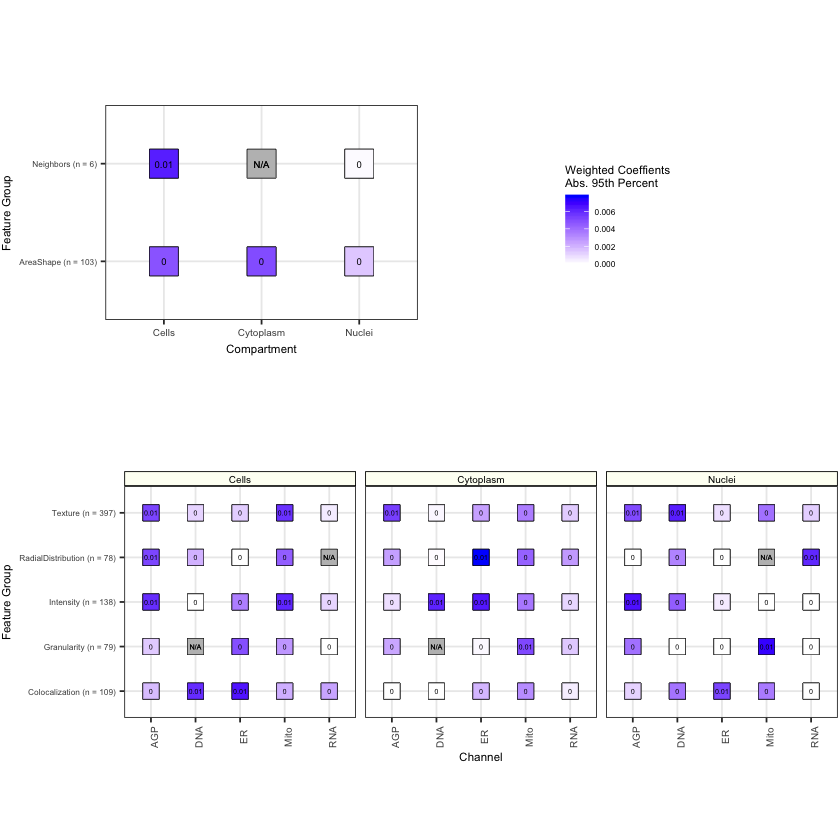

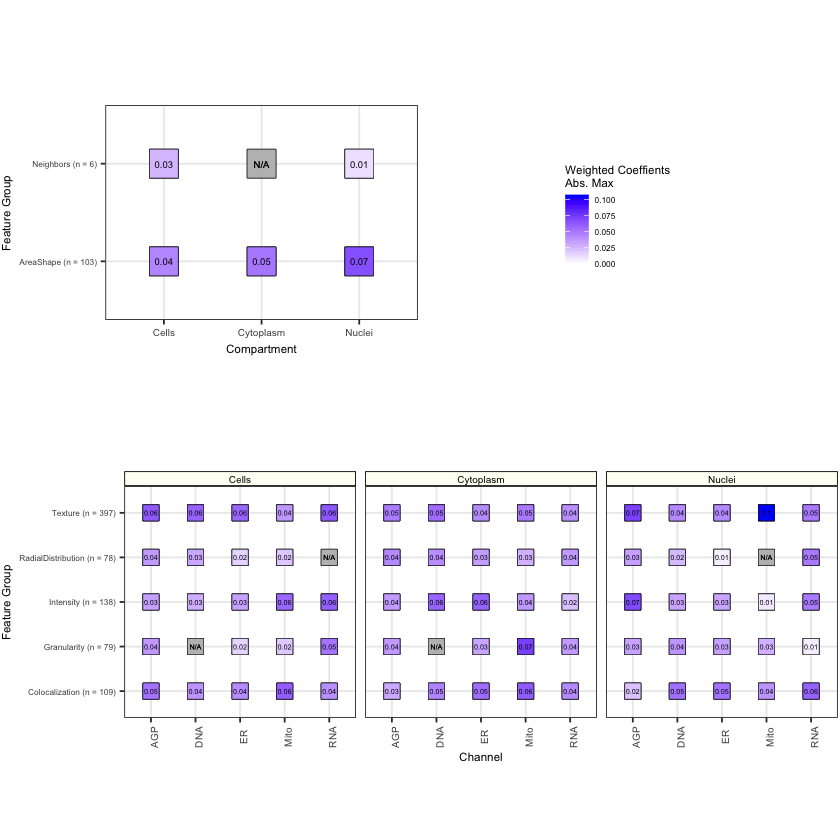

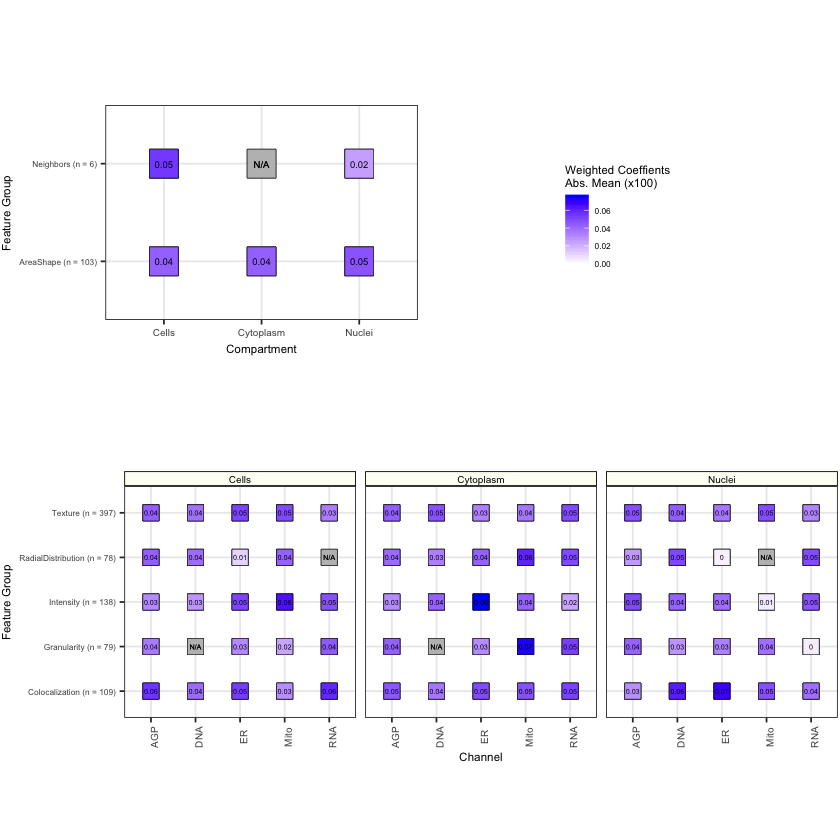

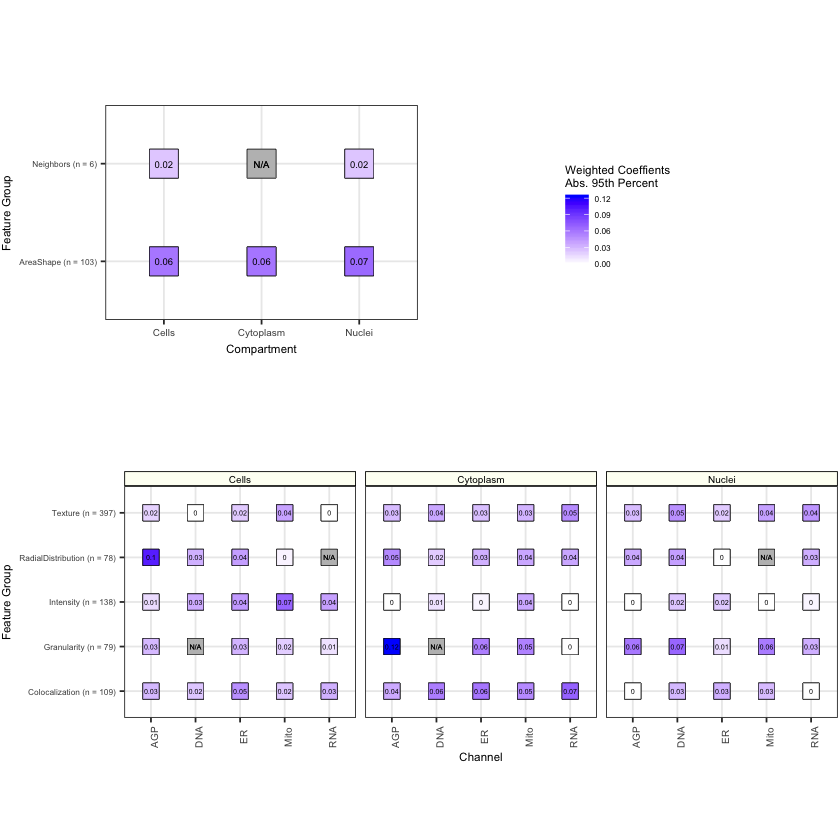

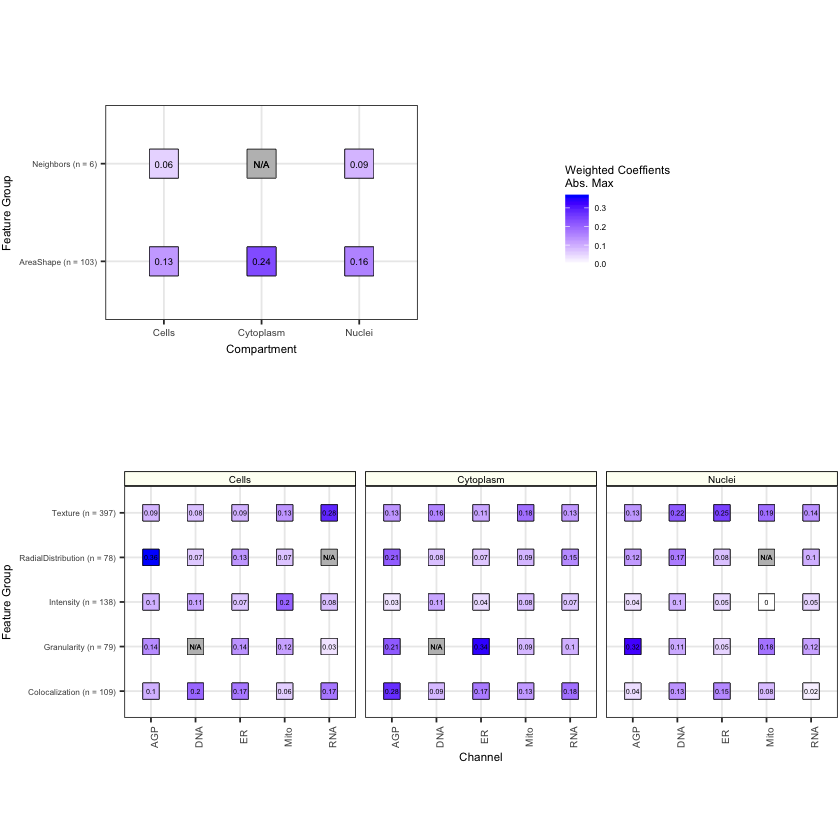

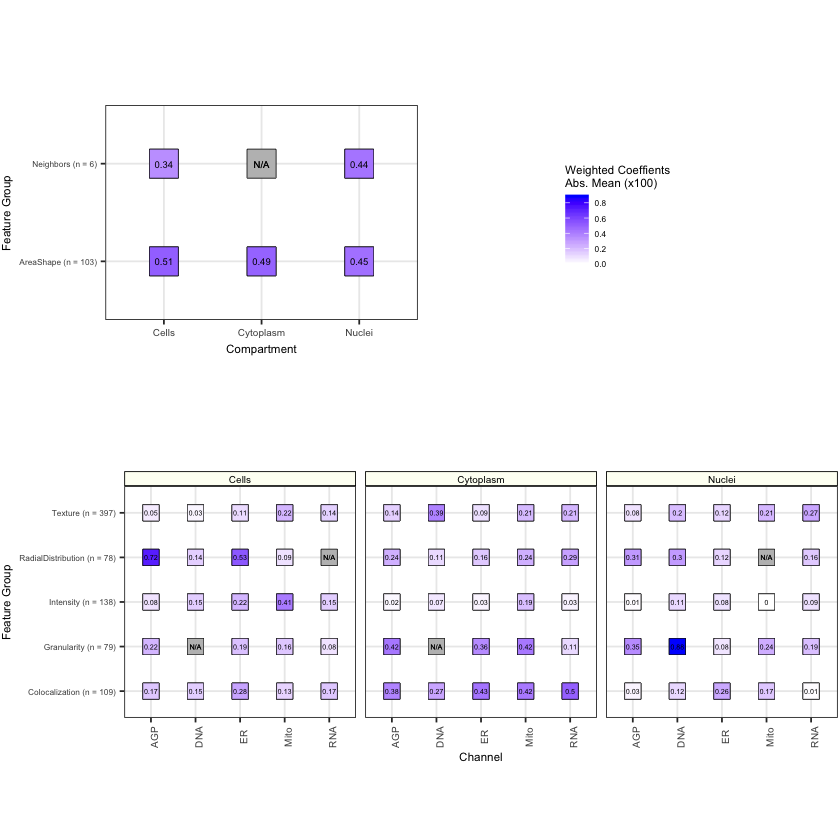

In [12]:
for (shuffle_option in c("Permuted", "Real")) {
    summary_subset_df <- coef_summary_df %>% dplyr::filter(shuffle == !!shuffle_option)
    
    for (summary_metric in summary_metrics) {

        if (summary_metric == "abs_mean") {
            column_choice <- "abs_mean_weight"
            stat_string <- "aggregated_mean"
            legend_name <- "Weighted Coeffients\nAbs. Mean (x100)"
        } else if (summary_metric == "abs_max") {
            column_choice <- "abs_max_weight"
            stat_string <- "aggregated_max"
            legend_name <- "Weighted Coeffients\nAbs. Max"
        } else if (summary_metric == "abs_95th") {
            column_choice <- "abs_95percentile"
            stat_string <- "aggregated_95th"
            legend_name <- "Weighted Coeffients\nAbs. 95th Percent"
        }

        # Process area different from other features
            area_df <- summary_subset_df %>%
                dplyr::filter(feature_group %in% c("AreaShape", "Neighbors")) %>%
                dplyr::group_by(compartment, feature_group, shuffle) %>%
                dplyr::mutate(
                    aggregated_max = max(abs_max_weight),
                    aggregated_mean = mean(abs_mean_weight) * 100,
                    aggregated_95th = quantile(abs_95percentile, 0.95),
                    feature_count = dplyr::n()
                ) %>%
                dplyr::select(
                    compartment, feature_group, shuffle, aggregated_max, aggregated_mean, aggregated_95th, feature_count
                ) %>%
                dplyr::distinct() %>%
                dplyr::ungroup() %>%
                dplyr::mutate(
                    aggregated_max_round = round(aggregated_max, 2),
                    aggregated_mean_round = round(aggregated_mean, 2),
                    aggregated_95th_round = round(aggregated_95th, 2)
                ) %>%
                dplyr::group_by(feature_group) %>%
                dplyr::mutate(
                    feature_group_count = sum(feature_count)
                ) %>%
                dplyr::ungroup() %>%
                dplyr::mutate(feature_group = paste0(feature_group, " (n = ", feature_group_count, ")"))

            area_df <- area_df %>%
                dplyr::mutate(weight_text = round(area_df[, stat_string], 2) %>% dplyr::pull(stat_string))

            area_comparments <- unique(area_df$compartment)
            area_feature_groups <- unique(area_df$feature_group)
            area_shuffle <- unique(area_df$shuffle)
            area_background <- tidyr::crossing(area_comparments, area_feature_groups, area_shuffle) %>%
                dplyr::mutate(weight_text = "N/A")
            colnames(area_background) <- c("compartment", "feature_group", "shuffle", "weight_text")

            # Process correlation different from other features
            corr_feature_group <- summary_subset_df %>%
                dplyr::filter(feature_group == "Correlation")

            corr_feature_count <- dim(corr_feature_group)[1]

            correlation_df <- corr_feature_group %>%
                dplyr::group_by(channel, compartment, shuffle) %>%
                dplyr::mutate(
                    aggregated_max = max(abs_max_weight),
                    aggregated_mean = mean(abs_mean_weight) * 100,
                    aggregated_95th = quantile(abs_95percentile, 0.95),
                ) %>%
                dplyr::select(
                    channel, compartment, shuffle, aggregated_max, aggregated_mean, aggregated_95th
                ) %>%
                dplyr::distinct() %>%
                dplyr::ungroup() %>%
                dplyr::mutate(
                    aggregated_max_round = round(aggregated_max, 2),
                    aggregated_mean_round = round(aggregated_mean, 2),
                    aggregated_95th_round = round(aggregated_95th, 2),
                ) %>%
                dplyr::mutate(feature_group_count = corr_feature_count,
                              feature_group = paste0("Colocalization (n = ", corr_feature_count, ")"))

            correlation_df <- correlation_df %>%
                dplyr::mutate(weight_text = round(correlation_df[, stat_string], 2) %>% dplyr::pull(stat_string)) 

            # Process compartment features different from other features
            compartment_df <- summary_subset_df %>%
                dplyr::filter(feature_group %in% !!compartment_features) %>%
                dplyr::group_by(compartment, channel, feature_group, shuffle) %>%
                dplyr::mutate(
                    aggregated_max = max(abs_max_weight),
                    aggregated_mean = mean(abs_mean_weight) * 100,
                    aggregated_95th = quantile(abs_95percentile, 0.95),
                    feature_count = dplyr::n()
                ) %>%
                dplyr::select(
                    compartment,
                    channel,
                    feature_group,
                    shuffle,
                    aggregated_max,
                    aggregated_mean,
                    aggregated_95th,
                    feature_count
                ) %>%
                dplyr::distinct() %>%
                dplyr::ungroup() %>%
                dplyr::mutate(
                    aggregated_max_round = round(aggregated_max, 2),
                    aggregated_mean_round = round(aggregated_mean, 2),
                    aggregated_95th_round = round(aggregated_95th, 2)
                ) %>%
                dplyr::group_by(feature_group) %>%
                dplyr::mutate(
                    feature_group_count = sum(feature_count)
                ) %>%
                dplyr::ungroup() %>%
                dplyr::mutate(feature_group = paste0(feature_group, " (n = ", feature_group_count, ")"))

            compartment_df <- compartment_df %>%
                dplyr::mutate(weight_text = round(compartment_df[, stat_string], 2) %>% dplyr::pull(stat_string)) 

            # Merge compartments with correlation data summary
            compartment_df <- dplyr::bind_rows(compartment_df, correlation_df)

            comp_comparments <- unique(compartment_df$compartment)
            comp_channels <- unique(compartment_df$channel)
            comp_feature_groups <- unique(compartment_df$feature_group)
            comp_shuffle <- unique(compartment_df$shuffle)
            comp_background <- tidyr::crossing(comp_comparments, comp_channels, comp_feature_groups, comp_shuffle) %>%
                dplyr::mutate(weight_text = "N/A")
            colnames(comp_background) <- c("compartment", "channel", "feature_group", "shuffle", "weight_text")

            max_gradient <- max(
                max(compartment_df %>% dplyr::pull(stat_string)),
                max(area_df %>% dplyr::pull(stat_string))
            )

        area_gg <- ggplot(area_df, aes(x = compartment, y = feature_group)) +
            geom_point(
                data = area_background,
                fill = "grey",
                size = point_size,
                pch = 22,
                stroke = 0.25
            ) +
            scale_fill_gradient2(
                name = legend_name,
                low = "white",
                high = "blue",
                limits = c(min_gradient, max_gradient)
            ) +
            ylab("Feature Group") +
            xlab("Compartment") +
            geom_text(
                aes(label = weight_text),
                size = 2,
                data = area_background
            ) +
            geom_point(
                aes_string(fill = stat_string),
                size = point_size,
                pch = 22,
                stroke = 0.25
            ) +
            geom_text(
                aes(label = weight_text),
                size = 2
            ) +
            theme_bw() +
            coord_fixed() +
            summary_coef_theme +
            theme(
                axis.text.x = element_text(size = 6),
                axis.text.y = element_text(size = 5),
                axis.title = element_text(size = 7)
            )

        compartment_gg <- ggplot(compartment_df,
                                 aes(x = channel, y = feature_group)) +
            geom_point(
                data = comp_background,
                fill = "grey",
                size = 5,
                pch = 22,
                stroke = 0.25
            ) +
            geom_text(
                aes(label = weight_text),
                size = 1.5,
                data = comp_background
            ) +
            geom_point(
                aes_string(fill = stat_string),
                size = 5,
                pch = 22,
                stroke = 0.25
            ) +
            geom_text(
                aes(label = weight_text),
                size = 1.5
            ) +
            facet_grid(~compartment) +
            scale_fill_gradient2(
                name = legend_name,
                low = "white",
                high = "blue",
                limits = c(min_gradient, max_gradient)
            ) +
            ylab("Feature Group") +
            xlab("Channel") +
            coord_fixed() +
            theme_bw() +
            summary_coef_theme +
            theme(
                axis.text.x = element_text(angle = 90, size = 6),
                axis.text.y = element_text(size = 5),
                axis.title = element_text(size = 7),
                strip.text = element_text(size = 6),
                legend.margin = margin(c(55, 5, 5, -10)),
                legend.title = element_text(size = 7),
                legend.text = element_text(size = 5)
            )

        # Compile full panel plot
        bottom_panel <- cowplot::plot_grid(
            compartment_gg + theme(legend.position = "none",
                                   plot.margin = margin(-20, 1.3, -50, 1.3))
            )

        main_legend_gg <- cowplot::get_legend(compartment_gg)

        top_panel <- cowplot::plot_grid(
            area_gg + theme(legend.position = "none",
                            plot.margin = margin(-30, 1.3, -100, 1.3)),
            main_legend_gg,
            ncol = 2,
            rel_widths = c(1.5, 1.5)
        )
        big_fig <- cowplot::plot_grid(
            top_panel,
            bottom_panel,
            nrow = 2,
            rel_heights = c(0.7, 1),
            align = "hv",
            axis = "l"
        )

        print(big_fig)

        output_file <- file.path(
            coef_dir,
            paste0(
                "figure_3_", shuffle_option, "_", consensus, "_", summary_metric, ".pdf"
            )
        )

        cowplot::save_plot(output_file, big_fig, base_height = 3.5, base_width = 4, dpi = 500)
    }
}

In [13]:
summary_metric <- "abs_mean"
shuffle_option <- "Real"

In [14]:
summary_subset_df <- coef_summary_df %>%
    dplyr::filter(shuffle == !!shuffle_option)

if (summary_metric == "abs_mean") {
    column_choice <- "abs_mean_weight"
    stat_string <- "aggregated_mean"
    legend_name <- "Weighted Coeffients\nAbs. Mean (x100)"
} else if (summary_metric == "abs_max") {
    column_choice <- "abs_max_weight"
    stat_string <- "aggregated_max"
    legend_name <- "Weighted Coeffients\nAbs. Max"
} else if (summary_metric == "abs_95th") {
    column_choice <- "abs_95percentile"
    stat_string <- "aggregated_95th"
    legend_name <- "Weighted Coeffients\nAbs. 95th Percent"
}

